# $\epsilon$-greedy

In [1]:
import jax
from jax import random
import jax.numpy as jnp
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import pandas as pd

In [168]:
%config InlineBackend.figure_format = "retina"
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False

## The 10-armed Testbed

In [204]:
key = random.PRNGKey(31415)

key_bandit, key_sample = random.split(key, 2)
n_bandits = 10
true_values = random.normal(key_bandit, (n_bandits,)) * 1.5
true_values

DeviceArray([ 0.14981222, -0.31885216,  2.1782422 , -1.2165844 ,
             -1.339469  ,  0.91874886, -2.7494972 ,  0.32193023,
             -1.2315878 ,  0.57459295], dtype=float32)

In [205]:
n_samples = 5000
bandit_samples = random.normal(key_sample, (n_bandits, n_samples)) + true_values[:, None]
bandit_samples.shape

(10, 5000)

In [206]:
bandit_samples = pd.DataFrame(bandit_samples.T).melt()
bandit_samples = bandit_samples.rename({"variable":"action", "value":"reward"}, axis=1)

(-4.0, 4.0)

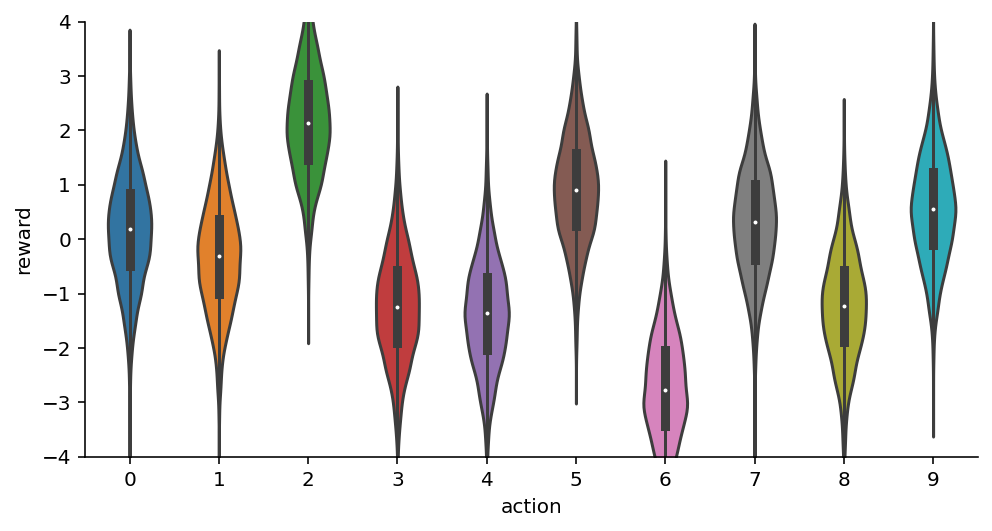

In [208]:
plt.subplots(figsize=(8, 4))
sns.violinplot(x="action", y="reward", data=bandit_samples, width=0.5)
plt.ylim(-4, 4)

## $\epsilon$-greedy method

$$
    Q_t(a) := \frac{\sum_{\tau=1}^{t-1} R_\tau \mathbb{1}(A_{\tau=a})}{\sum_{\tau=1}^{t-1} \mathbb{1}(A_{\tau=a})}
$$

In [263]:
num_steps = 1000
eps = 0.01
bandits = jnp.arange(n_bandits)
key_step = random.PRNGKey(315)

In [264]:
def take_greedy(state, key, eps):
    num_visits, rewards = state
    key_action, key_reward = random.split(key)
    
    Qt = num_visits * rewards / jnp.clip(num_visits, 1)
    take_greedy = (jax.random.uniform(key_action) < eps) * 1.0
    
    map_choice = Qt.max() == Qt
    prob_choice_Q = map_choice / map_choice.sum()
    greedy_actions = random.choice(key_action, bandits, p=prob_choice_Q)
    
    action = take_greedy * random.choice(key_action, bandits) + (1 - take_greedy) * greedy_actions
    reward = random.normal(key_reward) + true_values[action.astype(int)]
    
    num_visits = num_visits + jax.nn.one_hot(action, n_bandits)
    rewards = rewards + jax.nn.one_hot(action, n_bandits) * reward
    
    return (num_visits, rewards), (reward, action)

In [271]:
key = random.PRNGKey(315)
keys = random.split(key, num_steps)
num_visits = jnp.zeros(n_bandits)
rewards = jnp.zeros(n_bandits)

In [272]:
eps = 0.1

In [273]:
%%time
(num_visits_final, rewards_final), (rewards_samp, actions_samp) = jax.lax.scan(lambda state, key: take_greedy(state, key, eps), (num_visits, rewards), keys)

CPU times: user 1.36 s, sys: 8 ms, total: 1.37 s
Wall time: 1.29 s


In [275]:
eps_greedy_sims = jax.vmap(lambda key, eps: jax.lax.scan(lambda state, key: take_greedy(state, key, eps),
                                       (num_visits, rewards), random.split(key, num_steps)), in_axes=(0, None))

In [276]:
%%time
n_sims = 1500
keys = random.split(key, n_sims)
_, (reward_sims, action_sims) = eps_greedy_sims(keys, 0.3)

CPU times: user 2.24 s, sys: 70.1 ms, total: 2.31 s
Wall time: 1.51 s


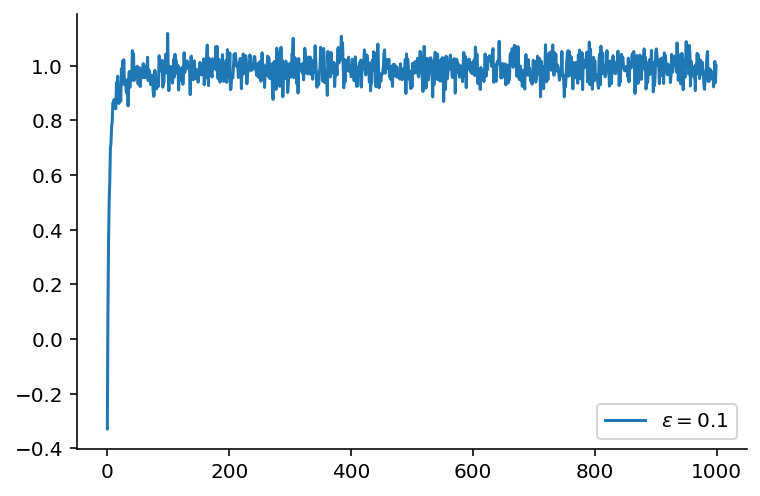

In [277]:
plt.plot(reward_sims.mean(axis=0), label="$\epsilon=$"f"{eps}")
plt.legend()

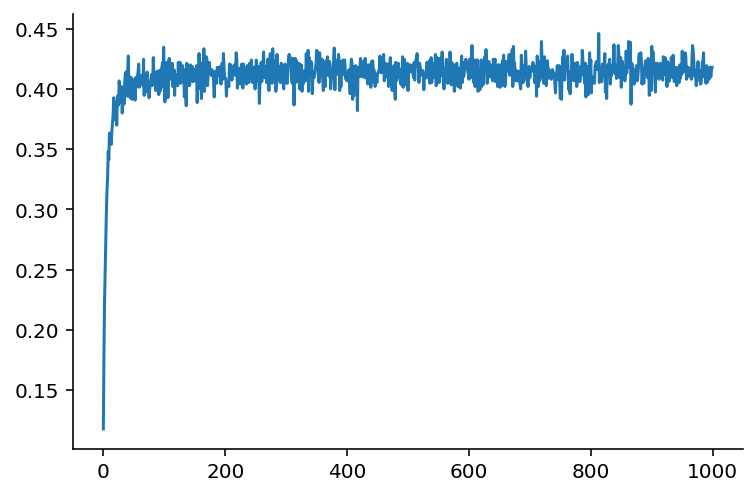

In [288]:
optimal_action_percent = (action_sims == true_values.argmax()).mean(axis=0)
plt.plot(optimal_action_percent)

In [289]:
%%time
eps_greedy_sims_multiple = jax.vmap(eps_greedy_sims, in_axes=(None, 0))
eps_values = jnp.array([0., 0.01, 0.1, 0.7])
_, (reward_sims_multiple, action_sims_multiple) = eps_greedy_sims_multiple(keys, eps_values)

CPU times: user 3.06 s, sys: 182 ms, total: 3.24 s
Wall time: 2.05 s


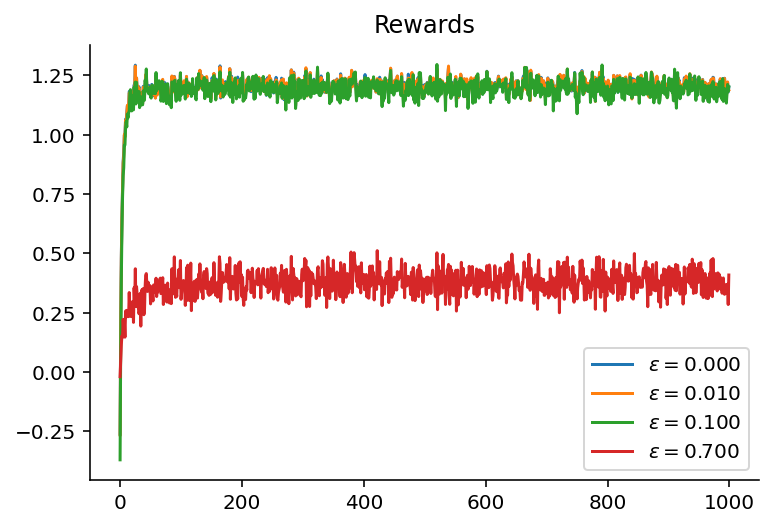

In [290]:
plt.plot(reward_sims_multiple.mean(axis=1).T)
legends = ["$\epsilon=$"f"{eps:0.3f}" for eps in eps_values]
plt.title("Rewards")
plt.legend(legends);

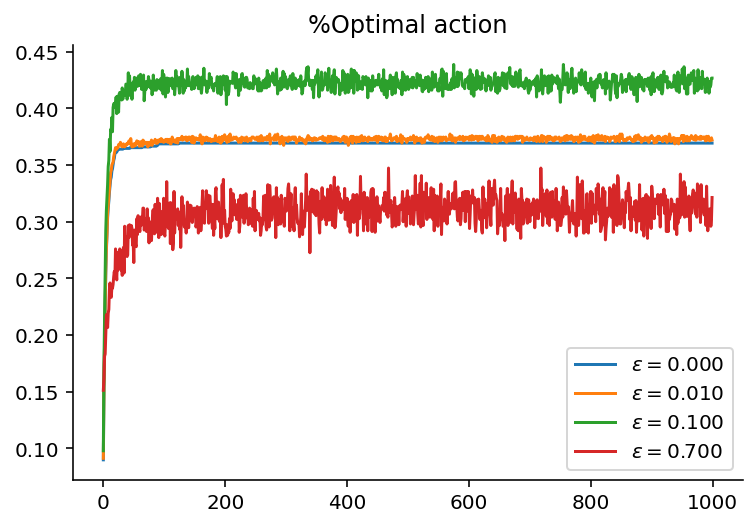

In [296]:
plt.title("%Optimal action")
plt.plot((action_sims_multiple == true_values.argmax()).mean(axis=1).T)
legends = ["$\epsilon=$"f"{eps:0.3f}" for eps in eps_values]
plt.legend(legends);